# Face Generation

In this project, you'll define and train a Generative Adverserial network of your own creation on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **defining new architectures training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset has higher resolution images than datasets you have previously worked with (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed-celeba-small/`. If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip).

In [22]:
# run this once to unzip the file
!unzip processed-celeba-small.zip

Archive:  processed-celeba-small.zip
replace processed_celeba_small/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 
error:  invalid response []
replace processed_celeba_small/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!pip install -r requirements.txt

In [1]:
from glob import glob
from typing import Tuple, Callable, Dict

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor, Resize, Normalize 

import tests

In [2]:
data_dir = 'processed_celeba_small/celeba/'

## Data pipeline

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA dataset and contains roughly 30,000 images. 

Your first task consists in building the dataloader. To do so, you need to do the following:
* implement the get_transforms function
* create a custom Dataset class that reads the CelebA data

### Exercise: implement the get_transforms function

The `get_transforms` function should output a [`torchvision.transforms.Compose`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose) of different transformations. You have two constraints:
* the function takes a tuple of size as input and should **resize the images** to the input size
* the output images should have values **ranging from -1 to 1**

In [3]:
def get_transforms(size: Tuple[int, int]) -> Callable:
    """ Transforms to apply to the image."""
    # TODO: edit this function by appening transforms to the below list
    transforms = [Resize(size),
                  ToTensor(),
                  Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]
    
    return Compose(transforms)

### Exercise: implement the DatasetDirectory class


The `DatasetDirectory` class is a torch Dataset that reads from the above data directory. The `__getitem__` method should output a transformed tensor and the `__len__` method should output the number of files in our dataset. You can look at [this custom dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) for ideas. 

In [4]:
class DatasetDirectory(Dataset):
    """
    A custom dataset class that loads images from folder.
    args:
    - directory: location of the images
    - transform: transform function to apply to the images
    - extension: file format
    """
    def __init__(self, 
                 directory: str, 
                 transforms: Callable = None, 
                 extension: str = '.jpg'):
        self.img_dir = directory
        self.img_type = extension
        self.transform = transforms
        self.list_all_images = glob(self.img_dir + '*' + self.img_type)

    def __len__(self) -> int:
        """ returns the number of items in the dataset """
        return len(self.list_all_images)

    def __getitem__(self, index: int) -> torch.Tensor:
        """ load an image and apply transformation """
        img_path = self.list_all_images[index]
        image = Image.open(img_path)
        image = self.transform(image)
        return image

In [5]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your dataset implementation
dataset = DatasetDirectory(data_dir, get_transforms((64, 64)))
tests.check_dataset_outputs(dataset)

Congrats, your dataset implementation passed all the tests


The functions below will help you visualize images from the dataset.

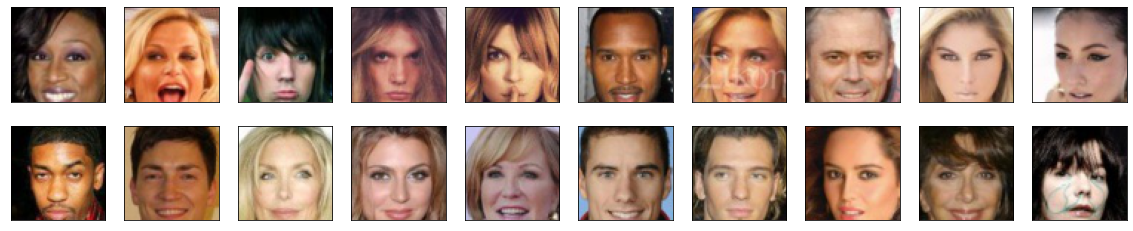

In [6]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def denormalize(images):
    """Transform images from [-1.0, 1.0] to [0, 255] and cast them to uint8."""
    return ((images + 1.) / 2. * 255).astype(np.uint8)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    img = dataset[idx].numpy()
    img = np.transpose(img, (1, 2, 0))
    img = denormalize(img)
    ax.imshow(img)

## Model implementation

As you know, a GAN is comprised of two adversarial networks, a discriminator and a generator. Now that we have a working data pipeline, we need to implement the discriminator and the generator. 

Feel free to implement any additional class or function.

### Exercise: Create the discriminator

The discriminator's job is to score real and fake images. You have two constraints here:
* the discriminator takes as input a **batch of 64x64x3 images**
* the output should be a single value (=score)

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips
* To scale down from the input image, you can either use `Conv2d` layers with the correct hyperparameters or Pooling layers.
* If you plan on using gradient penalty, do not use Batch Normalization layers in the discriminator.

In [7]:
from torch.nn import Module
from torch import nn

In [8]:
class ConvBlock(nn.Module):
    """
    A convolutional block is made of 3 layers: Conv -> BatchNorm -> Activation.
    args:
    - in_channels: number of channels in the input to the conv layer
    - out_channels: number of filters in the conv layer
    - kernel_size: filter dimension of the conv layer
    - batch_norm: whether to use batch norm or not
    """
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, batch_norm: bool = True):
        super(ConvBlock, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=2, padding=1, bias=False)
        self.batch_norm = batch_norm
        if self.batch_norm:
            self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(0.2)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        if self.batch_norm:
            x = self.bn(x)
        x = self.activation(x)
        return x

In [9]:
class Discriminator(Module):
    def __init__(self, conv_dim: int = 64):
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim

        # 64*64 input
        self.conv1 = ConvBlock(3, conv_dim, 4, batch_norm=False) # first layer, no batch_norm
        # 32*32 out
        self.conv2 = ConvBlock(conv_dim, conv_dim*2, 4)
        # 16*16 out
        self.conv3 = ConvBlock(conv_dim*2, conv_dim*4, 4)
        # 8*8 out
        self.conv4 = ConvBlock(conv_dim*4, conv_dim*8, 4)
        # 4*4 out
        
        self.flatten = nn.Flatten()
        
        # final, fully-connected layer
        self.fc = nn.Linear(conv_dim*4*8*4, 1)

    def forward(self, x):
        # all hidden layers + leaky relu activation
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # flatten
        x = self.flatten(x)
        # final output layer
        x = self.fc(x)   
        x = x[:, None, None] # weird stuff, not clear why this needed at all, we should only get batch, score and not something else.
        return x

In [10]:
discriminator = Discriminator()
images = torch.randn(1, 3, 64, 64)
score = discriminator(images)
print(score.shape)

torch.Size([1, 1, 1, 1])


In [11]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to check your discriminator implementation
discriminator = Discriminator()
tests.check_discriminator(discriminator)

torch.Size([1, 1, 1, 1])
Congrats, your discriminator implementation passed all the tests


### Exercise: create the generator

The generator's job creates the "fake images" and learns the dataset distribution. You have three constraints here:
* the generator takes as input a vector of dimension `[batch_size, latent_dimension, 1, 1]`
* the generator must outputs **64x64x3 images**

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips:
* to scale up from the latent vector input, you can use `ConvTranspose2d` layers
* as often with Gan, **Batch Normalization** helps with training

In [12]:
class DeconvBlock(nn.Module):
    """
    A "de-convolutional" block is made of 3 layers: ConvTranspose -> BatchNorm -> Activation.
    args:
    - in_channels: number of channels in the input to the conv layer
    - out_channels: number of filters in the conv layer
    - kernel_size: filter dimension of the conv layer
    - stride: stride of the conv layer
    - padding: padding of the conv layer
    - batch_norm: whether to use batch norm or not
    """
    def __init__(self, 
                 in_channels: int, 
                 out_channels: int, 
                 kernel_size: int, 
                 stride: int,
                 padding: int,
                 batch_norm: bool = True):
        super(DeconvBlock, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.batch_norm = batch_norm
        if self.batch_norm:
            self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.deconv(x)
        if self.batch_norm:
            x = self.bn(x)
        x = self.activation(x)
        return x

In [13]:
class Generator(nn.Module):
    """
    The generator model adapted from DCGAN
    args:
    - latent_dim: dimension of the latent vector
    - conv_dim: control the number of filters in the convtranspose layers
    """
    def __init__(self, latent_dim: int, conv_dim: int = 64):
        super(Generator, self).__init__()
        # transpose conv layers
        self.deconv1 = DeconvBlock(latent_dim, conv_dim*8, 4, 1, 0)
        self.deconv2 = DeconvBlock(conv_dim*8, conv_dim*4, 4, 2, 1)
        self.deconv3 = DeconvBlock(conv_dim*4, conv_dim*2, 4, 2, 1)
        self.deconv4 = DeconvBlock(conv_dim*2, conv_dim, 4, 2, 1)
        self.deconv_last = nn.ConvTranspose2d(conv_dim, 3, 4, stride=2, padding=1)
        self.last_activation = nn.Tanh()
        
    def forward(self, x):
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        x = self.deconv4(x)
        x = self.deconv_last(x)
        x = self.last_activation(x)
        return x

In [14]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your generator implementation
latent_dim = 128
generator = Generator(latent_dim)
tests.check_generator(generator, latent_dim)

Congrats, your generator implementation passed all the tests


## Optimizer

In the following section, we create the optimizers for the generator and discriminator. You may want to experiment with different optimizers, learning rates and other hyperparameters as they tend to impact the output quality.

### Exercise: implement the optimizers

In [15]:
import torch.optim as optim

def create_optimizers(generator: Module, discriminator: Module, lr, beta1, beta2):
    """ This function should return the optimizers of the generator and the discriminator """
    # TODO: implement the generator and discriminator optimizers
    g_optimizer = optim.Adam(generator.parameters(), lr, [beta1, beta2])
    d_optimizer = optim.Adam(discriminator.parameters(), lr, [beta1, beta2])
    return g_optimizer, d_optimizer

## Losses implementation

In this section, we are going to implement the loss function for the generator and the discriminator. You can and should experiment with different loss function.

Some tips:
* You can choose the commonly used the binary cross entropy loss or select other losses we have discovered in the course, such as the Wasserstein distance.
* You may want to implement a gradient penalty function as discussed in the course. It is not required and the code will work whether you implement it or not.

### Exercise: implement the generator loss

The generator's goal is to get the discriminator to think its generated images (= "fake" images) are real.

In [16]:
def generator_loss(fake_logits, smooth:bool = False):
    """ Generator loss, takes the fake scores as inputs. """
    batch_size = fake_logits.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    labels = labels.to(device)
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(fake_logits.squeeze(), labels)
    return loss

### Exercise: implement the discriminator loss

We want the discriminator to give high scores to real images and low scores to fake ones and the discriminator loss should reflect that.

In [17]:
def discriminator_loss(real_logits, fake_logits, smooth:bool = False):
    """ Discriminator loss, takes the fake and real logits as inputs. """
    # compute loss on real images using the generator loss
    d_real_loss = generator_loss(real_logits, smooth)
    # calc fake logits loss 
    batch_size = fake_logits.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    labels = labels.to(device)
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    d_fake_loss = criterion(fake_logits.squeeze(), labels)
    loss = d_real_loss + d_fake_loss
    return loss

### Exercise (Optional): Implement the gradient Penalty

In the course, we discussed the importance of gradient penalty in training certain types of Gans. Implementing this function is not required and depends on some of the design decision you made (discriminator architecture, loss functions).

In [18]:
def gradient_penalty(discriminator, real_samples, fake_samples):
    """ This function enforces """
    gp = 0
    # TODO (Optional): implement the gradient penalty
    return gp

## Training


Training will involve alternating between training the discriminator and the generator. You'll use your functions real_loss and fake_loss to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function

### Exercise: implement the generator step and the discriminator step functions

Each function should do the following:
* calculate the loss
* backpropagate the gradient
* perform one optimizer step

In [19]:
def generator_step(batch_size: int, latent_dim: int, smooth: bool = False) -> Dict:
    """ One training step of the generator. """
    g_optimizer.zero_grad()

    # 1. Forward Step with fake images and flipped labels

    # Generate fake images
    z = np.random.uniform(-1, 1, size=(batch_size, latent_dim, 1, 1))
    z = torch.from_numpy(z).float()
    z = z.to(device)
    # use the generator
    fake_images = generator(z)

    # Compute the discriminator losses on fake images 
    # using flipped labels!
    D_fake = discriminator(fake_images)
    g_loss = generator_loss(D_fake, smooth) # use generator loss to flip labels

    # perform backprop
    g_loss.backward()
    g_optimizer.step()
    return {'loss': g_loss}


def discriminator_step(batch_size: int, latent_dim: int, real_images: torch.Tensor, smooth: bool = False) -> Dict:
    """ One training step of the discriminator. """
    # TODO: implement the discriminator step (foward pass, loss calculation and backward pass)
    d_optimizer.zero_grad()
        
    # 1. Forwards step with real images
    real_images = real_images.to(device)
    D_real = discriminator(real_images)

    # 2. Forward step with fake images

    # Generate fake images
    z = np.random.uniform(-1, 1, size=(batch_size, latent_dim, 1, 1))
    z = torch.from_numpy(z).float()
    # move x to GPU, if available
    z = z.to(device)
    fake_images = generator(z)

    # Forward step for fake images
    D_fake = discriminator(fake_images.detach())
    
    # Calc loss for real and fake images
    d_loss = discriminator_loss(D_real, D_fake, smooth)
    

    # add up loss and perform backprop    
    d_loss.backward()
    d_optimizer.step()
    
    # calc gradient penalty
    real_samples = None
    fake_samples = None
    gp = gradient_penalty(discriminator, real_samples, fake_samples)

    return {'loss': d_loss, 'gp': gp}

### Main training loop

You don't have to implement anything here but you can experiment with different hyperparameters.

In [20]:
from datetime import datetime

In [21]:
# you can experiment with different dimensions of latent spaces
latent_dim = 128

# update to cpu if you do not have access to a gpu
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    # move models to GPU
    device = torch.device("cuda")
    print('GPU available for training.')
else:
    device = torch.device("cpu")
    print('Training on CPU.')

# number of epochs to train your model
n_epochs = 150

# number of images in each batch
batch_size = 64

# hyper params
lr = 0.0005
beta1=0.5
beta2=0.999 # default value

GPU available for training.


In [22]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
print_every = 100

# Create optimizers for the discriminator D and generator G
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
g_optimizer, d_optimizer = create_optimizers(generator, discriminator, lr, beta1, beta2)

dataloader = DataLoader(dataset, 
                        batch_size=64, 
                        shuffle=True, 
                        num_workers=4, 
                        drop_last=True,
                        pin_memory=False)

In [23]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def display(fixed_latent_vector: torch.Tensor):
    """ helper function to display images during training """
    fig = plt.figure(figsize=(14, 4))
    plot_size = 16
    for idx in np.arange(plot_size):
        ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
        img = fixed_latent_vector[idx, ...].detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = denormalize(img)
        ax.imshow(img)
    plt.show()

### Exercise: implement the training strategy

You should experiment with different training strategies. For example:

* train the generator more often than the discriminator. 
* added noise to the input image
* use label smoothing

Implement with your training strategy below.

2023-08-01 09:51:04 | Epoch [1/150] | Batch 0/509 | d_loss: 0.0272 | g_loss: 6.0230
2023-08-01 09:51:50 | Epoch [1/150] | Batch 100/509 | d_loss: 0.1183 | g_loss: 3.7600
2023-08-01 09:52:35 | Epoch [1/150] | Batch 200/509 | d_loss: 0.1008 | g_loss: 4.3291
2023-08-01 09:53:21 | Epoch [1/150] | Batch 300/509 | d_loss: 0.0851 | g_loss: 3.7416
2023-08-01 09:54:06 | Epoch [1/150] | Batch 400/509 | d_loss: 0.1197 | g_loss: 4.2562
2023-08-01 09:54:52 | Epoch [1/150] | Batch 500/509 | d_loss: 0.0412 | g_loss: 3.9301


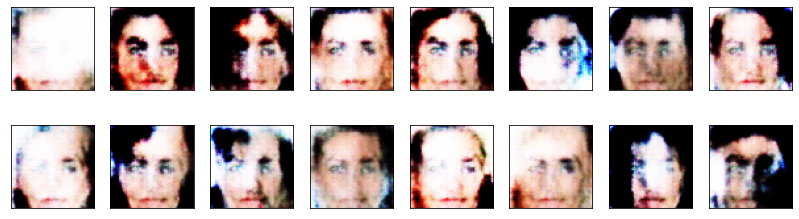

2023-08-01 09:54:58 | Epoch [2/150] | Batch 0/509 | d_loss: 0.1093 | g_loss: 4.0955
2023-08-01 09:55:44 | Epoch [2/150] | Batch 100/509 | d_loss: 0.0570 | g_loss: 4.4111
2023-08-01 09:56:29 | Epoch [2/150] | Batch 200/509 | d_loss: 0.0634 | g_loss: 3.8748
2023-08-01 09:57:14 | Epoch [2/150] | Batch 300/509 | d_loss: 0.0167 | g_loss: 6.8309
2023-08-01 09:58:00 | Epoch [2/150] | Batch 400/509 | d_loss: 0.0783 | g_loss: 5.9653
2023-08-01 09:58:46 | Epoch [2/150] | Batch 500/509 | d_loss: 0.0357 | g_loss: 6.2039
2023-08-01 09:58:51 | Epoch [3/150] | Batch 0/509 | d_loss: 0.1681 | g_loss: 5.9764
2023-08-01 09:59:37 | Epoch [3/150] | Batch 100/509 | d_loss: 0.0711 | g_loss: 5.3545
2023-08-01 10:00:22 | Epoch [3/150] | Batch 200/509 | d_loss: 0.0180 | g_loss: 6.5423
2023-08-01 10:01:08 | Epoch [3/150] | Batch 300/509 | d_loss: 0.0178 | g_loss: 7.3586
2023-08-01 10:01:53 | Epoch [3/150] | Batch 400/509 | d_loss: 0.0181 | g_loss: 5.2403
2023-08-01 10:02:39 | Epoch [3/150] | Batch 500/509 | d_lo

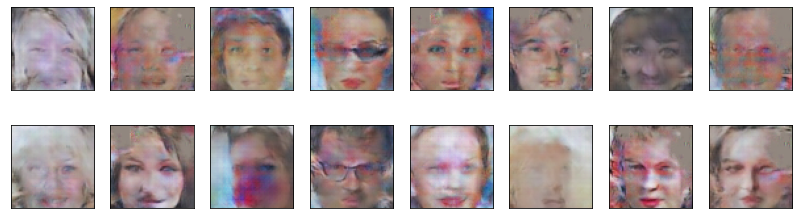

2023-08-01 10:33:48 | Epoch [12/150] | Batch 0/509 | d_loss: 0.0604 | g_loss: 6.7236
2023-08-01 10:34:33 | Epoch [12/150] | Batch 100/509 | d_loss: 0.0465 | g_loss: 5.8404
2023-08-01 10:35:19 | Epoch [12/150] | Batch 200/509 | d_loss: 0.1070 | g_loss: 6.1058
2023-08-01 10:36:04 | Epoch [12/150] | Batch 300/509 | d_loss: 0.0889 | g_loss: 5.2242
2023-08-01 10:36:50 | Epoch [12/150] | Batch 400/509 | d_loss: 0.4469 | g_loss: 3.6565
2023-08-01 10:37:35 | Epoch [12/150] | Batch 500/509 | d_loss: 0.0375 | g_loss: 5.5399
2023-08-01 10:37:41 | Epoch [13/150] | Batch 0/509 | d_loss: 0.6852 | g_loss: 5.8828
2023-08-01 10:38:26 | Epoch [13/150] | Batch 100/509 | d_loss: 0.0525 | g_loss: 5.9773
2023-08-01 10:39:11 | Epoch [13/150] | Batch 200/509 | d_loss: 0.4624 | g_loss: 4.3945
2023-08-01 10:39:56 | Epoch [13/150] | Batch 300/509 | d_loss: 0.0479 | g_loss: 5.2333
2023-08-01 10:40:42 | Epoch [13/150] | Batch 400/509 | d_loss: 0.1529 | g_loss: 5.6710
2023-08-01 10:41:27 | Epoch [13/150] | Batch 50

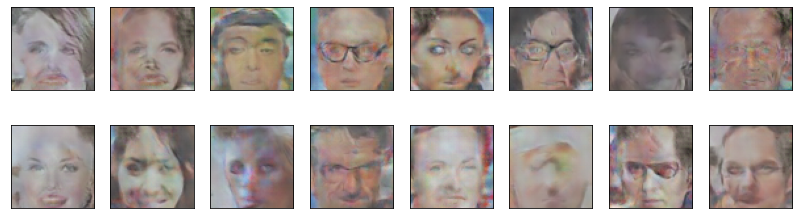

2023-08-01 11:12:28 | Epoch [22/150] | Batch 0/509 | d_loss: 0.1735 | g_loss: 6.5622
2023-08-01 11:13:13 | Epoch [22/150] | Batch 100/509 | d_loss: 0.6596 | g_loss: 7.2050
2023-08-01 11:13:59 | Epoch [22/150] | Batch 200/509 | d_loss: 0.0381 | g_loss: 7.7757
2023-08-01 11:14:44 | Epoch [22/150] | Batch 300/509 | d_loss: 1.0712 | g_loss: 11.9139
2023-08-01 11:15:29 | Epoch [22/150] | Batch 400/509 | d_loss: 0.0865 | g_loss: 8.4055
2023-08-01 11:16:14 | Epoch [22/150] | Batch 500/509 | d_loss: 0.0731 | g_loss: 6.9316
2023-08-01 11:16:20 | Epoch [23/150] | Batch 0/509 | d_loss: 0.0515 | g_loss: 6.9013
2023-08-01 11:17:06 | Epoch [23/150] | Batch 100/509 | d_loss: 0.2575 | g_loss: 5.3541
2023-08-01 11:17:51 | Epoch [23/150] | Batch 200/509 | d_loss: 0.0678 | g_loss: 4.6246
2023-08-01 11:18:36 | Epoch [23/150] | Batch 300/509 | d_loss: 0.0756 | g_loss: 6.2129
2023-08-01 11:19:22 | Epoch [23/150] | Batch 400/509 | d_loss: 0.0359 | g_loss: 7.0062
2023-08-01 11:20:08 | Epoch [23/150] | Batch 5

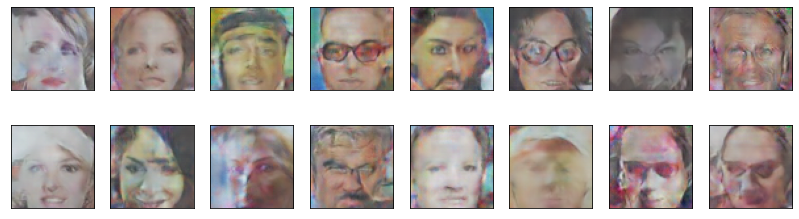

2023-08-01 11:51:26 | Epoch [32/150] | Batch 0/509 | d_loss: 0.0233 | g_loss: 6.5582
2023-08-01 11:52:12 | Epoch [32/150] | Batch 100/509 | d_loss: 0.0653 | g_loss: 7.9206
2023-08-01 11:52:58 | Epoch [32/150] | Batch 200/509 | d_loss: 0.0321 | g_loss: 8.7738
2023-08-01 11:53:43 | Epoch [32/150] | Batch 300/509 | d_loss: 3.1000 | g_loss: 13.6904
2023-08-01 11:54:30 | Epoch [32/150] | Batch 400/509 | d_loss: 0.0328 | g_loss: 5.0456
2023-08-01 11:55:16 | Epoch [32/150] | Batch 500/509 | d_loss: 0.0058 | g_loss: 9.5222
2023-08-01 11:55:21 | Epoch [33/150] | Batch 0/509 | d_loss: 0.0571 | g_loss: 6.4104
2023-08-01 11:56:07 | Epoch [33/150] | Batch 100/509 | d_loss: 0.0221 | g_loss: 6.2860
2023-08-01 11:56:53 | Epoch [33/150] | Batch 200/509 | d_loss: 0.1420 | g_loss: 6.6019
2023-08-01 11:57:38 | Epoch [33/150] | Batch 300/509 | d_loss: 0.7252 | g_loss: 8.0098
2023-08-01 11:58:24 | Epoch [33/150] | Batch 400/509 | d_loss: 0.0476 | g_loss: 7.0530
2023-08-01 11:59:09 | Epoch [33/150] | Batch 5

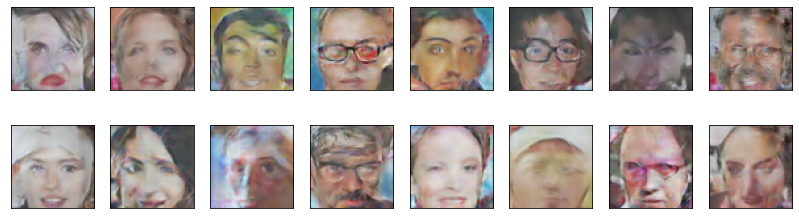

2023-08-01 12:31:50 | Epoch [42/150] | Batch 0/509 | d_loss: 0.0942 | g_loss: 8.4223
2023-08-01 12:32:39 | Epoch [42/150] | Batch 100/509 | d_loss: 0.9059 | g_loss: 10.8334
2023-08-01 12:33:29 | Epoch [42/150] | Batch 200/509 | d_loss: 0.0451 | g_loss: 6.8730
2023-08-01 12:34:19 | Epoch [42/150] | Batch 300/509 | d_loss: 0.0112 | g_loss: 6.3376
2023-08-01 12:35:09 | Epoch [42/150] | Batch 400/509 | d_loss: 0.0186 | g_loss: 6.6103
2023-08-01 12:35:59 | Epoch [42/150] | Batch 500/509 | d_loss: 0.0234 | g_loss: 5.4078
2023-08-01 12:36:05 | Epoch [43/150] | Batch 0/509 | d_loss: 0.0823 | g_loss: 6.3543
2023-08-01 12:36:56 | Epoch [43/150] | Batch 100/509 | d_loss: 0.0265 | g_loss: 7.8209
2023-08-01 12:37:46 | Epoch [43/150] | Batch 200/509 | d_loss: 0.0890 | g_loss: 3.6679
2023-08-01 12:38:36 | Epoch [43/150] | Batch 300/509 | d_loss: 0.0190 | g_loss: 6.4843
2023-08-01 12:39:25 | Epoch [43/150] | Batch 400/509 | d_loss: 0.1149 | g_loss: 5.4204
2023-08-01 12:40:16 | Epoch [43/150] | Batch 5

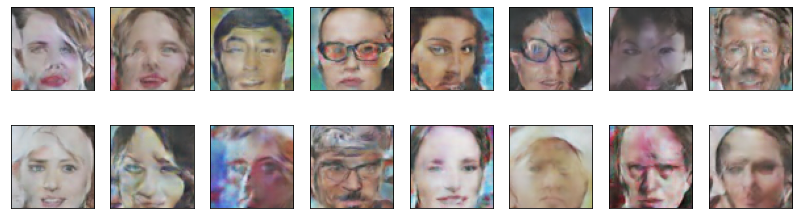

2023-08-01 13:13:22 | Epoch [52/150] | Batch 0/509 | d_loss: 0.0410 | g_loss: 6.4251
2023-08-01 13:14:13 | Epoch [52/150] | Batch 100/509 | d_loss: 0.0230 | g_loss: 5.5671
2023-08-01 13:15:02 | Epoch [52/150] | Batch 200/509 | d_loss: 0.0398 | g_loss: 7.4294
2023-08-01 13:15:52 | Epoch [52/150] | Batch 300/509 | d_loss: 0.0969 | g_loss: 6.1300
2023-08-01 13:16:44 | Epoch [52/150] | Batch 400/509 | d_loss: 0.0243 | g_loss: 6.7195
2023-08-01 13:17:34 | Epoch [52/150] | Batch 500/509 | d_loss: 0.0077 | g_loss: 7.3364
2023-08-01 13:17:41 | Epoch [53/150] | Batch 0/509 | d_loss: 0.0137 | g_loss: 5.4178
2023-08-01 13:18:31 | Epoch [53/150] | Batch 100/509 | d_loss: 0.1501 | g_loss: 7.2413
2023-08-01 13:19:22 | Epoch [53/150] | Batch 200/509 | d_loss: 0.4334 | g_loss: 9.4362
2023-08-01 13:20:13 | Epoch [53/150] | Batch 300/509 | d_loss: 0.2259 | g_loss: 8.1765
2023-08-01 13:21:04 | Epoch [53/150] | Batch 400/509 | d_loss: 0.0293 | g_loss: 6.3507
2023-08-01 13:21:54 | Epoch [53/150] | Batch 50

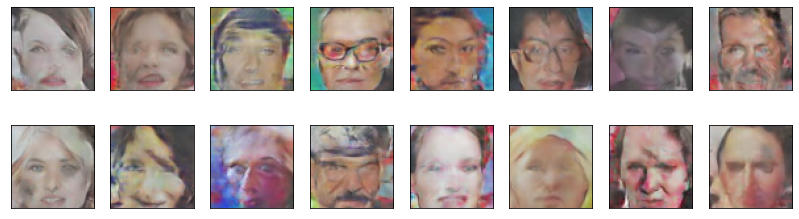

2023-08-01 13:54:33 | Epoch [62/150] | Batch 0/509 | d_loss: 0.0586 | g_loss: 4.4827
2023-08-01 13:55:19 | Epoch [62/150] | Batch 100/509 | d_loss: 0.0133 | g_loss: 7.2810
2023-08-01 13:56:04 | Epoch [62/150] | Batch 200/509 | d_loss: 0.0687 | g_loss: 7.1762
2023-08-01 13:56:50 | Epoch [62/150] | Batch 300/509 | d_loss: 0.0063 | g_loss: 7.7227
2023-08-01 13:57:36 | Epoch [62/150] | Batch 400/509 | d_loss: 0.1062 | g_loss: 8.2955
2023-08-01 13:58:22 | Epoch [62/150] | Batch 500/509 | d_loss: 0.0594 | g_loss: 6.6058
2023-08-01 13:58:27 | Epoch [63/150] | Batch 0/509 | d_loss: 0.0305 | g_loss: 6.8617
2023-08-01 13:59:13 | Epoch [63/150] | Batch 100/509 | d_loss: 0.0248 | g_loss: 7.7819
2023-08-01 13:59:59 | Epoch [63/150] | Batch 200/509 | d_loss: 0.2446 | g_loss: 7.9580
2023-08-01 14:00:45 | Epoch [63/150] | Batch 300/509 | d_loss: 0.0146 | g_loss: 5.4516
2023-08-01 14:01:31 | Epoch [63/150] | Batch 400/509 | d_loss: 0.0163 | g_loss: 9.8482
2023-08-01 14:02:17 | Epoch [63/150] | Batch 50

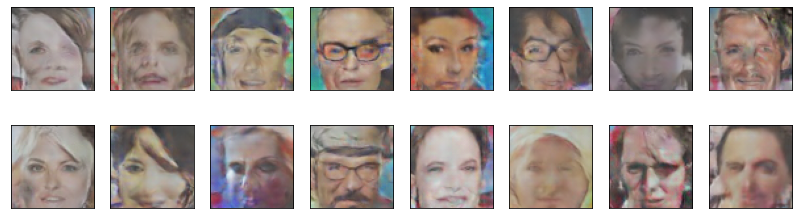

2023-08-01 14:33:37 | Epoch [72/150] | Batch 0/509 | d_loss: 0.0039 | g_loss: 8.2369


In [ ]:
fixed_latent_vector = torch.randn(16, latent_dim, 1, 1).float().to(device)

losses = []

for epoch in range(n_epochs):
    for batch_i, real_images in enumerate(dataloader):
        real_images = real_images.to(device)

        # get batch size
        batch_size = real_images.size(0)
        # important rescaling step
        # real_images = scale(real_images)

        # Train the discriminator
        # apply label smoothing on the discriminator only
        smoothing = True
        d_1_loss = discriminator_step(batch_size, latent_dim, real_images, smoothing) # {'loss': d_loss, 'gp': gp}
        # apply 2 discriminator steps per one generator Two Times Update Rule
        d_loss = discriminator_step(batch_size, latent_dim, real_images, smoothing)
        # Train the generator
        g_loss = generator_step(batch_size, latent_dim, False) # {'loss': g_loss}

        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            d = d_loss['loss'].item()
            g = g_loss['loss'].item()
            losses.append((d, g))
            # print discriminator and generator loss
            time = str(datetime.now()).split('.')[0]
            print(f'{time} | Epoch [{epoch+1}/{n_epochs}] | Batch {batch_i}/{len(dataloader)} | d_loss: {d:.4f} | g_loss: {g:.4f}')

    if epoch % 10 == 0:
        # display images during training
        generator.eval()
        generated_images = generator(fixed_latent_vector)
        display(generated_images)
        generator.train()

### Training losses

Plot the training losses for the generator and discriminator.

In [ ]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()